# Instacart Recommender System - Data Processing
---

## Table of Contents

* [1. Data Preparation](#chapter1)
    * [1.1 Combine Data](#chapter1_1)
    * [1.2 Group Data by Aisle/Department](#chapter1_2)
    * [1.3 Compute Aisle/Department share](#chapter1_3)
* [2. Principal Component Analysis](#chapter2)
* [3. K-Means Clustering](#chapter3)
* [4. File Exports](#chapter4)

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from IPython.display import clear_output

In [26]:
aisles = pd.read_csv('../data/aisles.csv')
dept = pd.read_csv('../data/departments.csv')
order_prod__train = pd.read_csv('../data/order_products__train.csv')
order_prod__prior = pd.read_csv('../data/order_products__prior.csv')
orders = pd.read_csv('../data/orders.csv')
products = pd.read_csv('../data/products.csv')

## 1. Data Preparation <a class="anchor" id="chapter1"></a>
---

In order to cluster the customers by aisles, order information will be combined with product, aislem and department to get a complete database of orders.

### 1.1 Combine Data <a class="anchor" id="chapter1_1"></a>

In [27]:
# Combine prior and train data
complete_orders = pd.concat([order_prod__prior, order_prod__train], axis=0)
# Get aisle and department id for products
complete_orders = complete_orders.merge(products[['product_id','aisle_id','department_id']], how='inner', on='product_id')
# Get aisle name
complete_orders = complete_orders.merge(aisles, on='aisle_id')
# Get department name
complete_orders = complete_orders.merge(dept, on='department_id')
# Get user id for all products ordered
complete_orders = complete_orders.merge(orders[['order_id','user_id']], on='order_id')

display(complete_orders.head())

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,aisle,department,user_id
0,2,33120,1,1,86,16,eggs,dairy eggs,202279
1,2,28985,2,1,83,4,fresh vegetables,produce,202279
2,2,17794,6,1,83,4,fresh vegetables,produce,202279
3,2,43668,9,0,123,4,packaged vegetables fruits,produce,202279
4,2,9327,3,0,104,13,spices seasonings,pantry,202279


### 1.2 Group Data by Aisle/Department <a class="anchor" id="chapter1_2"></a>

In [28]:
# Compile number of units of products bought from each aisle/department for each user
aisle_sum = complete_orders[['user_id','add_to_cart_order','aisle']].groupby(['user_id','aisle']).sum().reset_index()
dept_sum = complete_orders[['user_id','add_to_cart_order','department']].groupby(['user_id','department']).sum().reset_index()

display(aisle_sum.head())
display(dept_sum.head())

,user_id,aisle,add_to_cart_order
0,1,candy chocolate,8
1,1,cereal,26
2,1,cream,17
3,1,fresh fruits,30
4,1,milk,9


,user_id,department,add_to_cart_order
0,1,beverages,35
1,1,breakfast,26
2,1,dairy eggs,76
3,1,household,14
4,1,pantry,5


In [29]:
# Compile total volume of order units for each user
user_volume = aisle_sum.groupby('user_id')[['add_to_cart_order']].sum()
user_volume = user_volume.rename(columns = {'add_to_cart_order':'volume'})

# Merge volume on user_id
aisle_sum = aisle_sum.merge(user_volume, how='inner', on='user_id')
dept_sum = dept_sum.merge(user_volume, how='inner', on='user_id')

display(aisle_sum.head())
display(dept_sum.head())

,user_id,aisle,add_to_cart_order,volume
0,1,candy chocolate,8,280
1,1,cereal,26,280
2,1,cream,17,280
3,1,fresh fruits,30,280
4,1,milk,9,280


,user_id,department,add_to_cart_order,volume
0,1,beverages,35,280
1,1,breakfast,26,280
2,1,dairy eggs,76,280
3,1,household,14,280
4,1,pantry,5,280


### 1.3 Compute Aisle/Department Share <a class="anchor" id="chapter1_3"></a>

In [30]:
# Compute share of each aisle/department by total volume
aisle_sum['aisle_share'] = aisle_sum['add_to_cart_order'] / aisle_sum['volume']
dept_sum['dept_share'] = dept_sum['add_to_cart_order'] / dept_sum['volume']

In [31]:
# Obtain dataframe of share of aisle/department by each individual user
aisle_share = aisle_sum[['user_id','aisle','aisle_share']].pivot(index='user_id',
                                                                 columns='aisle', 
                                                                 values='aisle_share')
aisle_share.fillna(value=0,inplace=True)
display(aisle_share.head())

dept_share = dept_sum[['user_id','department','dept_share']].pivot(index='user_id', 
                                                                   columns='department', 
                                                                   values = 'dept_share')
dept_share.fillna(value=0,inplace=True)
display(dept_share.head())

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.017857,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.025000
2,0.00000,0.010628,0.0,0.0,0.0,0.0,0.004159,0.0,0.0,0.0,...,0.023105,0.003235,0.006932,0.00,0.0,0.0,0.0,0.008318,0.0,0.186229
3,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.038363,0.012788,0.000000,0.00,0.0,0.0,0.0,0.028133,0.0,0.000000
4,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.06,0.0,0.0,0.0,0.040000,0.0,0.000000
5,0.02008,0.076305,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.064257


department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.0,0.000000,0.125000,0.092857,0.0,0.000000,0.271429,0.000000,0.000000,...,0.050000,0.000000,0.000000,0.0,0.0,0.017857,0.000000,0.0,0.107143,0.335714
2,0.00,0.0,0.012939,0.034658,0.009704,0.0,0.040665,0.209335,0.091959,0.000000,...,0.000000,0.010628,0.005545,0.0,0.0,0.040665,0.011091,0.0,0.159889,0.143715
3,0.00,0.0,0.000000,0.040921,0.000000,0.0,0.000000,0.158568,0.028133,0.038363,...,0.012788,0.000000,0.000000,0.0,0.0,0.038363,0.000000,0.0,0.452685,0.145780
4,0.04,0.0,0.080000,0.120000,0.000000,0.0,0.020000,0.000000,0.100000,0.000000,...,0.120000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.220000,0.020000
5,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.032129,0.196787,0.004016,0.008032,...,0.020080,0.076305,0.000000,0.0,0.0,0.032129,0.000000,0.0,0.570281,0.032129


## 2. Principal Component Analysis (PCA) <a class="anchor" id="chapter2"></a>
---

The aisle share has a total of 134 columns, with many of the aisle values being 0. In order to reduce the amount of features, Principal Component Analysis (PCA) will be employed for feature extraction.

In [32]:
# Instantiate, fit and transform PCA
pca = PCA(n_components = 36)
pca_components = pca.fit_transform(aisle_share)
# Assign to dataframe
pca_components = pd.DataFrame(pca_components)

In [33]:
# Obtain cumulative variance
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
pca_var = pd.DataFrame(data=[var_exp,cum_var_exp]).T
pca_var.rename({0: 'var', 1: 'cum_var'}, axis=1, inplace=True)
display(pca_var.tail())

,var,cum_var
31,0.007329,0.777244
32,0.006943,0.784187
33,0.006877,0.791064
34,0.006732,0.797796
35,0.006601,0.804396


With 36 components, 80% of the variance from the original population can be explained.

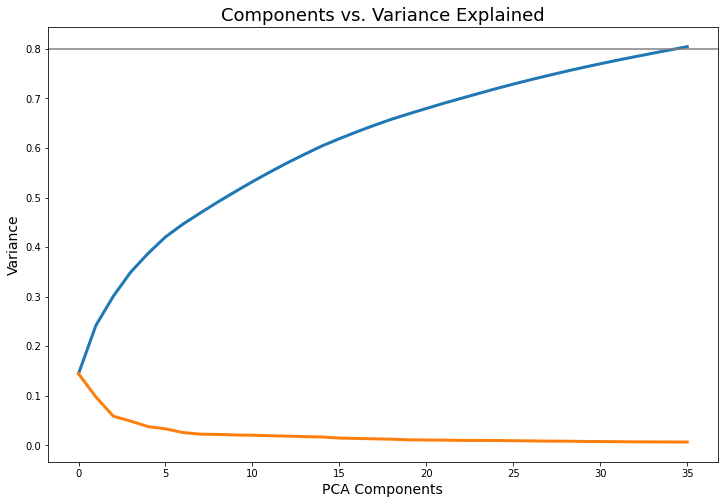

In [34]:
# Plot components vs variance explained
plt.figure(figsize=(12,8))
plt.plot(cum_var_exp, lw=3, label='Cumulative Variance')
plt.plot(var_exp, lw=3, label='Variance Explained')
plt.axhline(y=0.8, color='grey')
plt.title('Components vs. Variance Explained', fontsize=18)
plt.ylabel('Variance', fontsize=14)
plt.xlabel('PCA Components', fontsize=14)
plt.savefig('../assets/pca.png');

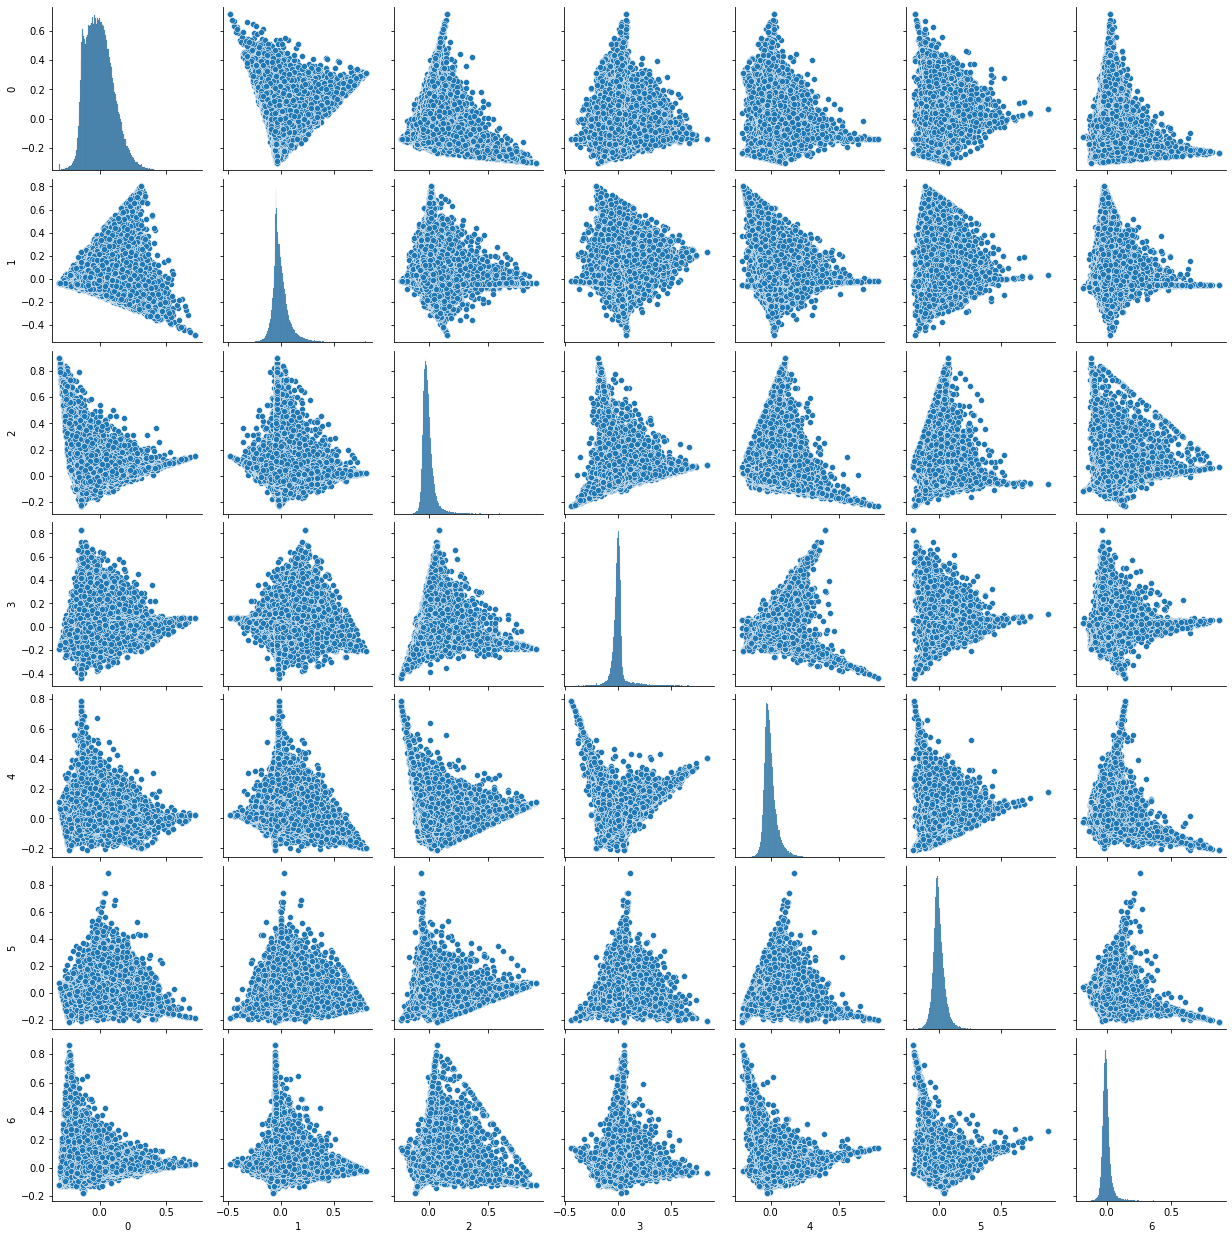

In [36]:
# Pairplot for first 7 components of PCA
sns.pairplot(pca_components[[0,1,2,3,4,5,6]])
plt.savefig('../assets/pairplot.png');

## 3. K-Means Clustering <a class="anchor" id="chapter3"></a>

PCA has managed to reduce number of features from 134 to 36, with 36 components explaining for 80% of the variance in the original population. Based on the PCA results, clustering techniques will be employed to group the various users into different groups.

K-Means clustering aims to reduce the sum of squared distances from each point to the mean point of the cluster is minimised. However, the number of clusters needs to first be decided upon. A trial of clusters between 2 and 20 will be tested and the SSE of each cluster will be collected to evaluate the results.

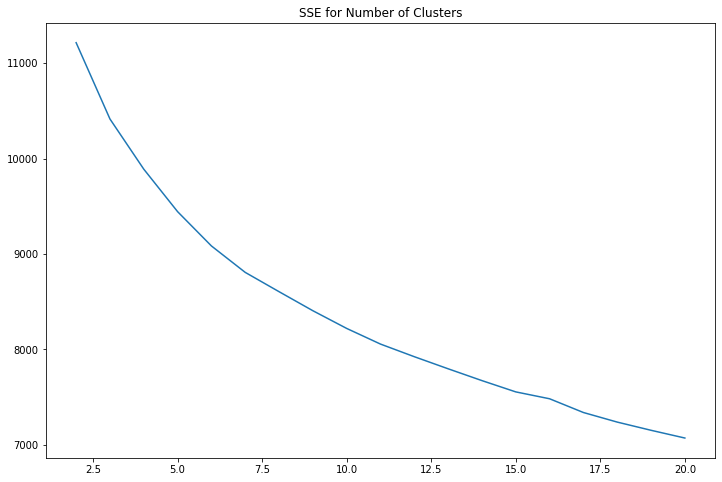

In [37]:
sse = {}
labels = {}
for k in range(2,21):
    print(f"Processing for {k}/20 clusters...")
    kmeans = KMeans(n_clusters=k).fit(pca_components)
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_
    clear_output(wait=True)

plt.figure(figsize=(12,8))
plt.title("SSE for Number of Clusters")
plt.plot(list(sse.keys()), list(sse.values()));

In [38]:
# Put values of SSE into dataframe
sse_df = pd.DataFrame([sse.keys(), sse.values()]).T.rename({0:'n_clusters', 1:'sse'},axis=1)
# Compute decrease in SSE when clusters increase
sse_df['diff'] = sse_df['sse'] - sse_df['sse'].shift(1)

display(sse_df)

,n_clusters,sse,diff
0,2.0,11215.332323,NaN
1,3.0,10415.097714,-800.234609
2,4.0,9888.894542,-526.203172
3,5.0,9443.309125,-445.585417
4,6.0,9083.689438,-359.619687
5,7.0,8806.309189,-277.380249
6,8.0,8603.961708,-202.347481
7,9.0,8404.283978,-199.677730
8,10.0,8218.537271,-185.746707
9,11.0,8054.403322,-164.133949


SSE decreases significantly till about 6 clusters, where it then continue to gradually decrease.

6 clusters will be used as the number of clusters.

In [39]:
# Assign K-Means clusters to PCA dataframe
cluster_df = pd.concat([pca_components, pd.Series(labels[6]).rename('cluster')], axis=1)
display(cluster_df.head())

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,cluster
0,-0.103161,0.048617,-0.031836,-0.005635,-0.053014,-0.055233,0.077097,-0.059357,-0.044011,0.024204,...,0.047360,-0.031997,-0.015426,0.002597,0.001861,-0.000531,-0.013612,0.010495,0.000298,0
1,-0.077766,0.077983,-0.076149,-0.101671,0.081781,-0.040411,-0.011286,0.060062,0.094827,0.093882,...,-0.016723,-0.012726,0.003405,0.008603,-0.014492,0.034138,0.004464,0.009656,-0.008430,0
2,0.057496,0.085719,0.001778,-0.013191,-0.028500,0.113061,0.009642,0.005263,0.015878,-0.019315,...,-0.016775,-0.005992,-0.012893,-0.021508,0.005594,-0.010863,0.008701,0.022330,-0.021323,1
3,-0.055343,0.134731,-0.002393,-0.037706,-0.087805,-0.027369,-0.023199,0.024732,0.142973,0.174471,...,-0.031423,-0.012562,0.004583,0.077022,-0.022390,0.012871,-0.018564,-0.004868,0.022339,3
4,0.133936,-0.019591,-0.020960,-0.003730,0.057736,0.138881,0.046987,-0.012729,0.000042,-0.034593,...,-0.009468,0.011169,-0.003843,-0.005083,0.024594,-0.006746,0.002618,-0.004897,0.003201,5


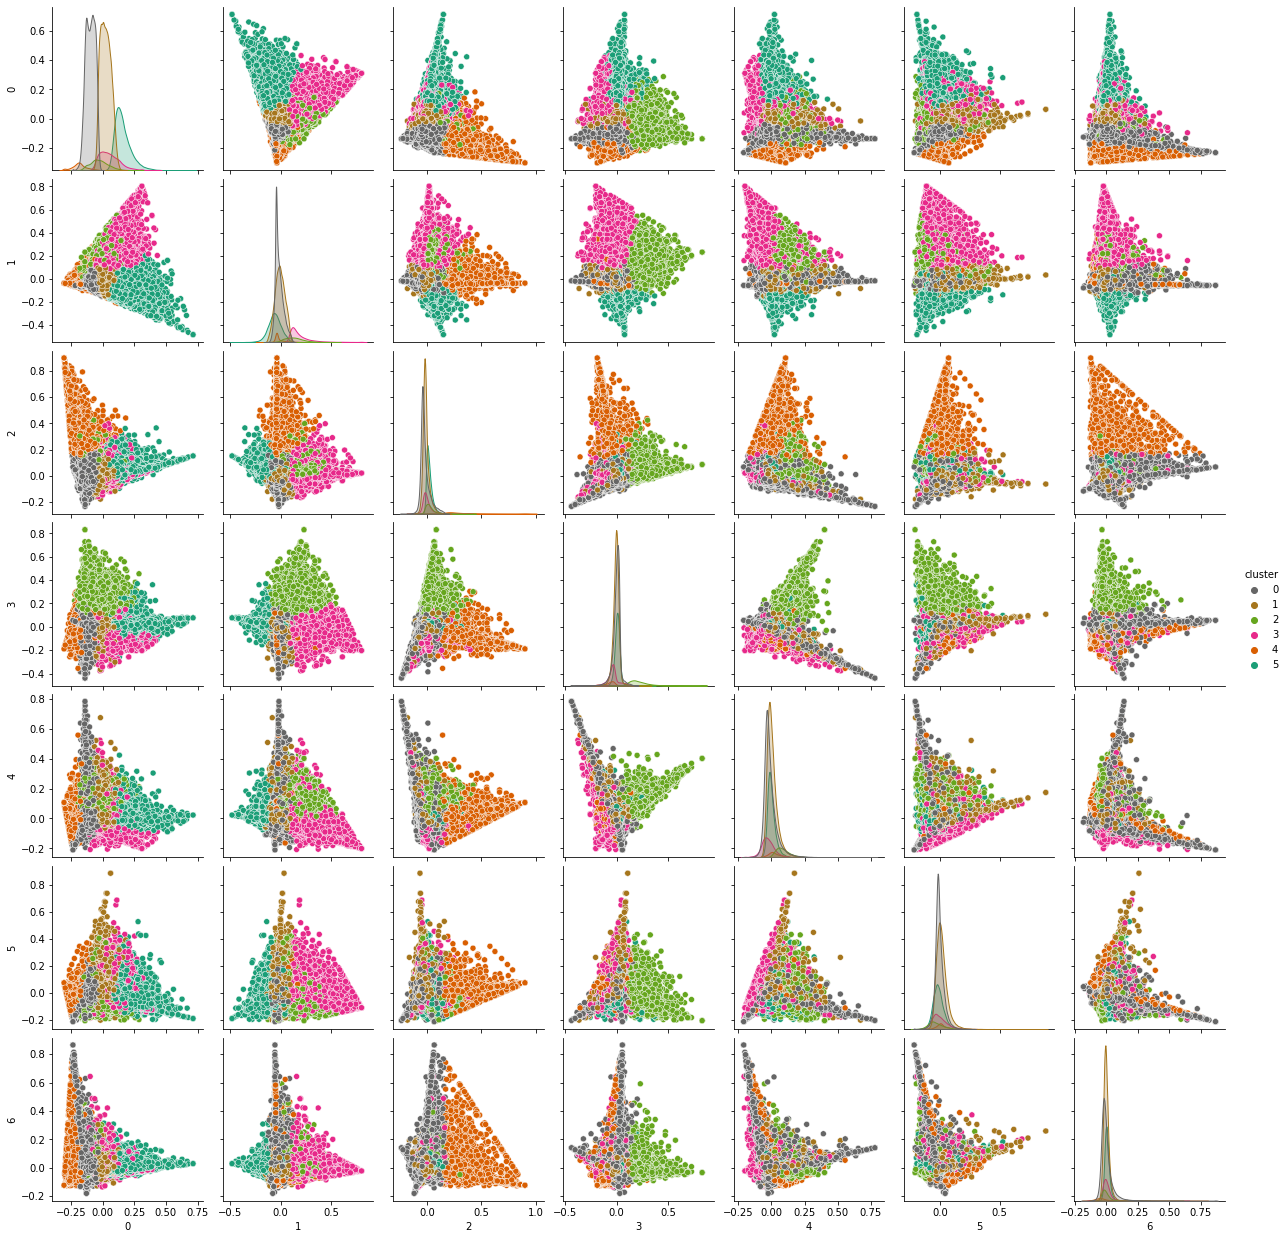

In [40]:
# Pairplot for first 7 components of PCA, with cluster as hue
sns.pairplot(cluster_df[[0,1,2,3,4,5,6,'cluster']], hue='cluster', palette='Dark2_r')
plt.savefig('../assets/pairplot_cluster.png');

Pairplot reveals certain prominent groups revealed by the clustering. Given that PCA has been employed, inference on which aisles are causing the differences that lead to the clusters cannot be obtained. 

The clusters will be assigned back to the user based aisle distribution to see if reasons for the clusters can be obtained.

In [41]:
# Add user_id to cluster_df
cluster_df = pd.concat([pd.Series(aisle_share.index), cluster_df], axis=1)

# Add cluster to aisle/data data based on user_id
aisle_sum = aisle_sum.merge(cluster_df[['user_id','cluster']], on='user_id')
dept_sum = dept_sum.merge(cluster_df[['user_id','cluster']], on='user_id')

In [42]:
# For each cluster, obtain the breakdown on the share of aisles
cluster_aisles = pd.DataFrame(columns = ['aisle','add_to_cart_order','aisle_share','cluster'])
# Iterate through 6 clusters
for n in range(0,6):
    t1 = aisle_sum[aisle_sum['cluster'] == n]
    t1 = t1.groupby('aisle')[['add_to_cart_order']].sum().reset_index()
    t1['aisle_share'] = t1['add_to_cart_order']
    t1['aisle_share'] = t1['aisle_share'].apply(lambda y: y / t1['add_to_cart_order'].sum())
    t1['cluster'] = n
    cluster_aisles = pd.concat([t1,cluster_aisles], axis = 0)
    
display(cluster_aisles.head())

,aisle,add_to_cart_order,aisle_share,cluster
0,air fresheners candles,10216,0.000218,5
1,asian foods,349185,0.007460,5
2,baby accessories,7633,0.000163,5
3,baby bath body care,8174,0.000175,5
4,baby food formula,265885,0.005681,5


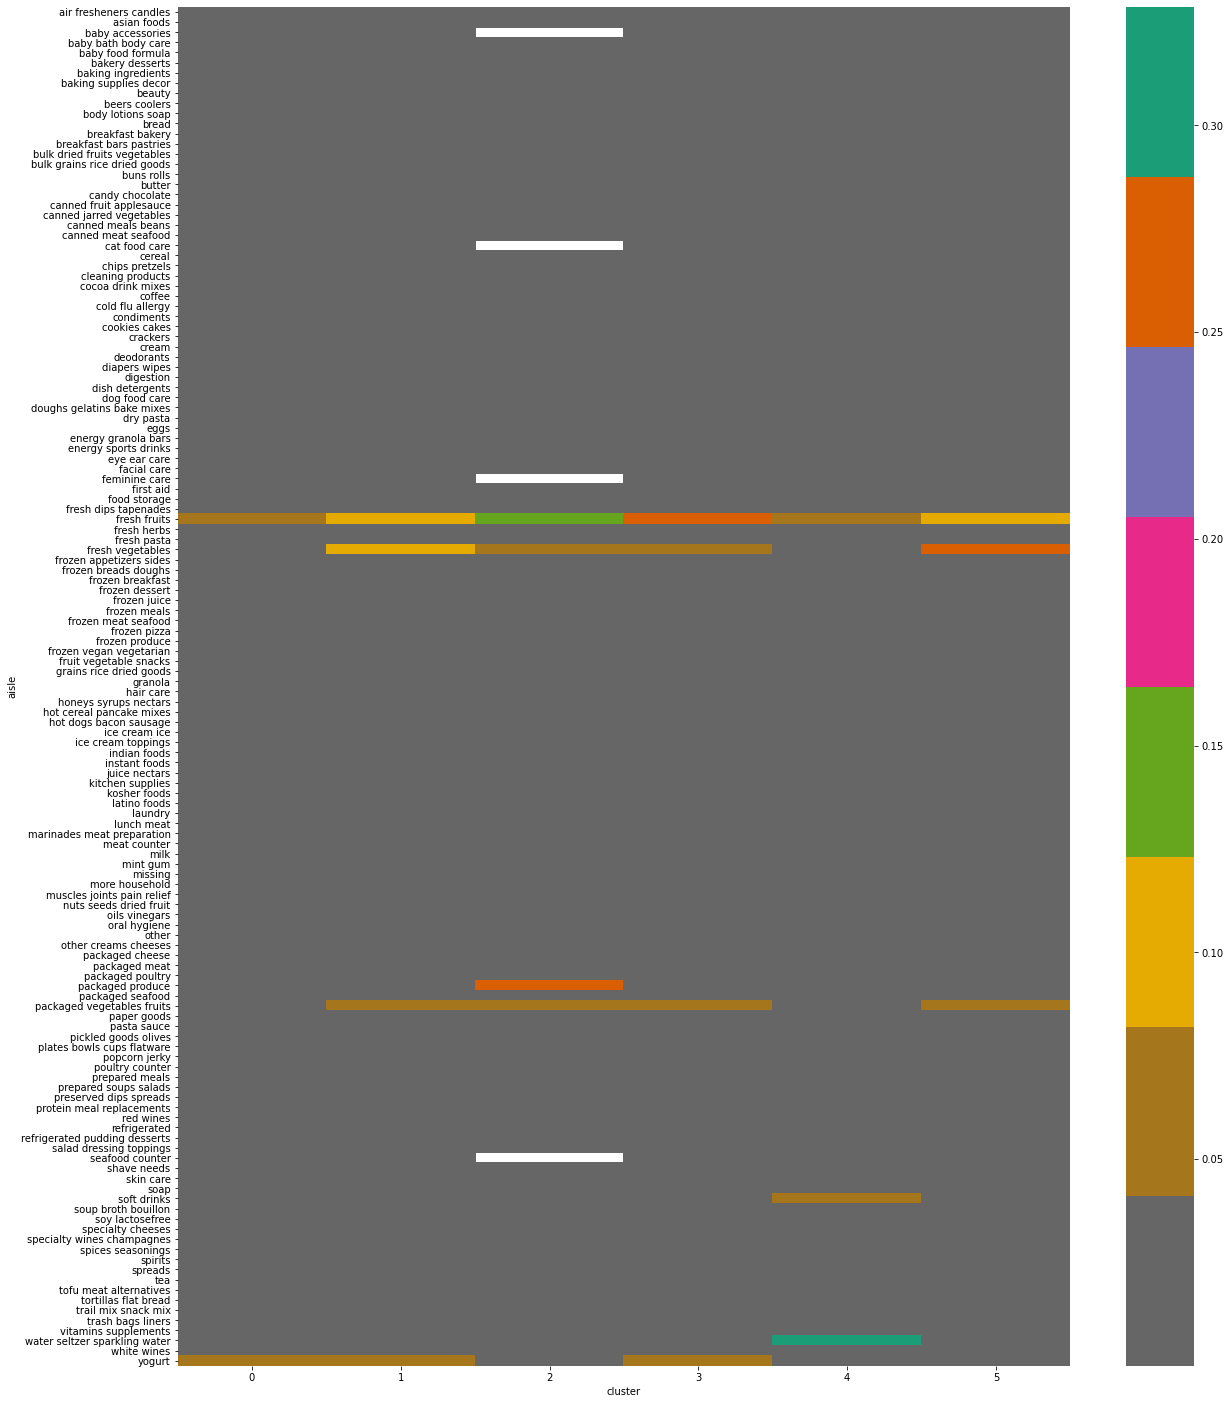

In [43]:
# Plot cluster heatmap
aisle_heat = cluster_aisles.pivot(index = 'aisle', columns = 'cluster', values = 'aisle_share')
plt.figure(figsize=(20,25))
sns.heatmap(aisle_heat, cmap='Dark2_r')
plt.savefig('../assets/aisle_heatmap.png');

Heatmap reveals certain perferences within the clusters.
- Cluster 0: Yogurt and fresh fruit
- Cluster 1: Baby accessories, cat food, feminie care, fresh fruits, fresh vegetables, packaged produce, packaged vegetable fruits, and seafood
- Cluster 2: Fresh fruits, fresh vegetables, packaged vegetable fruits, and yogurt
- Cluster 3: Fresh fruits, soft drinks, and sparkling water
- Cluster 4: Fresh fruits, fresh vegetables, and packaged vegetable fruits
- Cluster 5: Fresh fruits, fresh vegetables, packaged vegetable fruits, and yogurt

In [44]:
cluster_dept_br = pd.DataFrame(columns = ['department','add_to_cart_order','dept_share','cluster'])
for i in range(0,6):
    x = dept_sum[dept_sum['cluster'] == i]
    x = x.groupby('department')['add_to_cart_order'].sum().reset_index()
    x['dept_share'] = x['add_to_cart_order']
    x['dept_share'] = x['dept_share'].apply(lambda f: f / x['add_to_cart_order'].sum())
    x['cluster'] = i
    cluster_dept_br = pd.concat([x,cluster_dept_br], axis = 0)

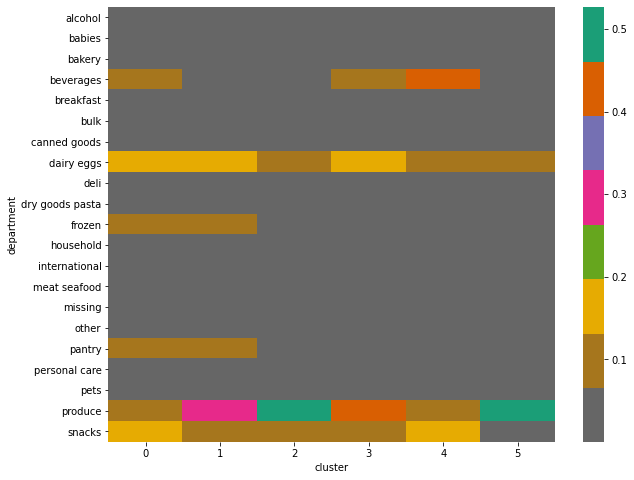

In [45]:
dept_heat = cluster_dept_br.pivot(index = 'department', columns = 'cluster', values = 'dept_share')
plt.figure(figsize=(10,8))
sns.heatmap(dept_heat,cmap="Dark2_r");

Department heatmap shows general preferences with varying degrees in dairy eggs, produce, and snacks. Cluster 0 and 2 shows inclinations to frozen and pantry departments, and cluster 3 and 5 showing preferences for beverages.

## 4. File Exports <a class="anchor" id="chapter4"></a>

In [21]:
cluster_df.to_csv('../data/cluster_data.csv', index=False)

In [22]:
complete_orders = complete_orders.merge(cluster_df[['user_id', 'cluster']], on='user_id')
complete_orders.to_csv('../data/complete_orders.csv', index=False)

In [24]:
pca_components.to_csv('../data/pca_components.csv')